In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import optuna

df = pd.read_csv('data/data_featured.csv', sep=';', encoding='utf-8')
df = df.drop(columns='Unnamed: 0').dropna()

X = df[['SiteEnergyUseWN(kBtu)']]
y = df['TotalGHGEmissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), ['SiteEnergyUseWN(kBtu)'])
])

models = ["Ridge", "Lasso", "ElasticNet", "SVR", "RandomForest", "GradientBoosting", "XGBoost"]

results = []

for model_name in models:
    
    def objective(trial):
        if model_name == "Ridge":
            alpha = trial.suggest_loguniform("alpha", 1e-3, 1e3)
            model = Ridge(alpha=alpha, max_iter=10000)
        elif model_name == "Lasso":
            alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
            model = Lasso(alpha=alpha, max_iter=10000)
        elif model_name == "ElasticNet":
            alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
            l1_ratio = trial.suggest_uniform("l1_ratio", 0.0, 1.0)
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
        elif model_name == "SVR":
            C = trial.suggest_loguniform("C", 0.1, 1000)
            epsilon = trial.suggest_uniform("epsilon", 0.01, 1)
            kernel = trial.suggest_categorical("kernel", ["rbf", "poly"])
            model = SVR(C=C, epsilon=epsilon, kernel=kernel)
        elif model_name == "RandomForest":
            n_estimators = trial.suggest_int("n_estimators", 100, 800)
            max_depth = trial.suggest_int("max_depth", 3, 50)
            min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
            min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
            max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_features=max_features,
                random_state=42
            )
        elif model_name == "GradientBoosting":
            n_estimators = trial.suggest_int("n_estimators", 100, 500)
            learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
            max_depth = trial.suggest_int("max_depth", 3, 7)
            subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
            model = GradientBoostingRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=subsample,
                random_state=42
            )
        elif model_name == "XGBoost":
            n_estimators = trial.suggest_int("n_estimators", 100, 500)
            learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
            max_depth = trial.suggest_int("max_depth", 3, 10)
            subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
            colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)
            model = XGBRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                random_state=42,
                objective='reg:squarederror'
            )
        
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model)
        ])
        
        pipe.fit(X_train, y_train)
        return pipe.score(X_test, y_test)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30, n_jobs=1, show_progress_bar=True)
    
    results.append({
        "Model": model_name,
        "BestParams": study.best_params,
        "R2": study.best_value
    })

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)


[I 2025-08-26 17:37:26,086] A new study created in memory with name: no-name-b66bd0bc-2fcc-4f82-ac3b-649360749593
  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_74307/1484120960.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-3, 1e3)
Best trial: 0. Best value: 0.817629:   0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_74307/1484120960.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-3, 1e3)
Best trial: 1. Best value: 0.817634:   3%|▎         | 1/30 [00:00<00:00, 30.62it/s]/tmp/ipykernel_74307/1484120960.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-3, 1e3)
Best trial: 1. Best value: 0.817634:   7%|▋         | 2/30 [00:00<00:00, 42.39it/s]/tmp/ipykernel_74307/1484120960.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) i

[I 2025-08-26 17:37:26,103] Trial 0 finished with value: 0.8176291264263513 and parameters: {'alpha': 1.395684632325984}. Best is trial 0 with value: 0.8176291264263513.
[I 2025-08-26 17:37:26,117] Trial 1 finished with value: 0.8176335789583028 and parameters: {'alpha': 0.04016542680469248}. Best is trial 1 with value: 0.8176335789583028.
[I 2025-08-26 17:37:26,131] Trial 2 finished with value: 0.8176335532035405 and parameters: {'alpha': 0.05032326392466394}. Best is trial 1 with value: 0.8176335789583028.
[I 2025-08-26 17:37:26,144] Trial 3 finished with value: 0.8176314284672441 and parameters: {'alpha': 0.7721507541749615}. Best is trial 1 with value: 0.8176335789583028.
[I 2025-08-26 17:37:26,156] Trial 4 finished with value: 0.8176335949964393 and parameters: {'alpha': 0.03381681586629197}. Best is trial 4 with value: 0.8176335949964393.
[I 2025-08-26 17:37:26,172] Trial 5 finished with value: 0.8086221995147521 and parameters: {'alpha': 138.97333628071286}. Best is trial 4 with

/tmp/ipykernel_74307/1484120960.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-3, 1e3)
Best trial: 12. Best value: 0.817634:  40%|████      | 12/30 [00:00<00:00, 63.55it/s]/tmp/ipykernel_74307/1484120960.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-3, 1e3)
Best trial: 12. Best value: 0.817634:  47%|████▋     | 14/30 [00:00<00:00, 55.44it/s]/tmp/ipykernel_74307/1484120960.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=Tru

[I 2025-08-26 17:37:26,315] Trial 12 finished with value: 0.8176336771048573 and parameters: {'alpha': 0.0010311095206327978}. Best is trial 12 with value: 0.8176336771048573.
[I 2025-08-26 17:37:26,330] Trial 13 finished with value: 0.8176336647486782 and parameters: {'alpha': 0.00599569368055987}. Best is trial 12 with value: 0.8176336771048573.
[I 2025-08-26 17:37:26,358] Trial 14 finished with value: 0.8176336543881919 and parameters: {'alpha': 0.010149931620593789}. Best is trial 12 with value: 0.8176336771048573.
[I 2025-08-26 17:37:26,391] Trial 15 finished with value: 0.817471681281688 and parameters: {'alpha': 15.116480567056609}. Best is trial 12 with value: 0.8176336771048573.
[I 2025-08-26 17:37:26,410] Trial 16 finished with value: 0.8176333050178923 and parameters: {'alpha': 0.14598116702502809}. Best is trial 12 with value: 0.8176336771048573.
[I 2025-08-26 17:37:26,422] Trial 17 finished with value: 0.8176336770624422 and parameters: {'alpha': 0.0010481704051474299}. Be

Best trial: 21. Best value: 0.817634:  83%|████████▎ | 25/30 [00:00<00:00, 53.90it/s]/tmp/ipykernel_74307/1484120960.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-3, 1e3)
Best trial: 21. Best value: 0.817634:  87%|████████▋ | 26/30 [00:00<00:00, 53.90it/s]/tmp/ipykernel_74307/1484120960.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-3, 1e3)
Best trial: 21. Best value: 0.817634:  93%|█████████▎| 28/30 [00:00<00:00, 62.09it/s]/tmp/ipykernel_74307/1484120960.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See

[I 2025-08-26 17:37:26,525] Trial 25 finished with value: 0.8176336740845914 and parameters: {'alpha': 0.002245642598817814}. Best is trial 21 with value: 0.8176336771267207.
[I 2025-08-26 17:37:26,540] Trial 26 finished with value: 0.7361648802219277 and parameters: {'alpha': 552.8582141555154}. Best is trial 21 with value: 0.8176336771267207.
[I 2025-08-26 17:37:26,552] Trial 27 finished with value: 0.8176336770571204 and parameters: {'alpha': 0.0010503110316873244}. Best is trial 21 with value: 0.8176336771267207.
[I 2025-08-26 17:37:26,569] Trial 28 finished with value: 0.817633146569724 and parameters: {'alpha': 0.2050846319007378}. Best is trial 21 with value: 0.8176336771267207.
[I 2025-08-26 17:37:26,586] Trial 29 finished with value: 0.8176336692851712 and parameters: {'alpha': 0.00417426225779957}. Best is trial 21 with value: 0.8176336771267207.


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
Best trial: 0. Best value: 0.817634:   0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
Best trial: 1. Best value: 0.817634:   3%|▎         | 1/30 [00:00<00:01, 25.77it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use su

[I 2025-08-26 17:37:26,612] Trial 0 finished with value: 0.8176335096907629 and parameters: {'alpha': 7.17096988255685e-05}. Best is trial 0 with value: 0.8176335096907629.
[I 2025-08-26 17:37:26,626] Trial 1 finished with value: 0.81763365263728 and parameters: {'alpha': 1.1548578096537849e-05}. Best is trial 1 with value: 0.81763365263728.
[I 2025-08-26 17:37:26,649] Trial 2 finished with value: 0.8176335776250557 and parameters: {'alpha': 4.3306380749276713e-05}. Best is trial 1 with value: 0.81763365263728.
[I 2025-08-26 17:37:26,672] Trial 3 finished with value: 0.8176332837726502 and parameters: {'alpha': 0.0001638677911588291}. Best is trial 1 with value: 0.81763365263728.
[I 2025-08-26 17:37:26,692] Trial 4 finished with value: 0.8174632740151512 and parameters: {'alpha': 0.01634873313865319}. Best is trial 1 with value: 0.81763365263728.
[I 2025-08-26 17:37:26,717] Trial 5 finished with value: 0.8176334113608772 and parameters: {'alpha': 0.00011224341726047882}. Best is trial 

Best trial: 1. Best value: 0.817634:  20%|██        | 6/30 [00:00<00:00, 49.97it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
Best trial: 1. Best value: 0.817634:  23%|██▎       | 7/30 [00:00<00:00, 49.97it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
Best trial: 1. Best value: 0.817634:  27%|██▋       | 8/30 [00:00<00:00, 49.97it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:/

[I 2025-08-26 17:37:26,736] Trial 6 finished with value: 0.8176312971420818 and parameters: {'alpha': 0.0008627078811146191}. Best is trial 1 with value: 0.81763365263728.
[I 2025-08-26 17:37:26,753] Trial 7 finished with value: -0.00039508397666576656 and parameters: {'alpha': 6.002307235562264}. Best is trial 1 with value: 0.81763365263728.
[I 2025-08-26 17:37:26,768] Trial 8 finished with value: 0.8176139631822369 and parameters: {'alpha': 0.004379781926604226}. Best is trial 1 with value: 0.81763365263728.
[I 2025-08-26 17:37:26,787] Trial 9 finished with value: 0.8042480265656647 and parameters: {'alpha': 0.1621448157780602}. Best is trial 1 with value: 0.81763365263728.


Best trial: 10. Best value: 0.817634:  33%|███▎      | 10/30 [00:00<00:00, 49.68it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
Best trial: 10. Best value: 0.817634:  37%|███▋      | 11/30 [00:00<00:00, 49.68it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
Best trial: 12. Best value: 0.817634:  40%|████      | 12/30 [00:00<00:00, 49.68it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See h

[I 2025-08-26 17:37:26,820] Trial 10 finished with value: 0.8176336546567102 and parameters: {'alpha': 1.0687733857791524e-05}. Best is trial 10 with value: 0.8176336546567102.
[I 2025-08-26 17:37:26,838] Trial 11 finished with value: 0.8176336469254157 and parameters: {'alpha': 1.3981745778533046e-05}. Best is trial 10 with value: 0.8176336546567102.
[I 2025-08-26 17:37:26,854] Trial 12 finished with value: 0.8176336558197086 and parameters: {'alpha': 1.0191828103069308e-05}. Best is trial 12 with value: 0.8176336558197086.
[I 2025-08-26 17:37:26,872] Trial 13 finished with value: 0.8176302053154312 and parameters: {'alpha': 0.0011886505389736505}. Best is trial 12 with value: 0.8176336558197086.
[I 2025-08-26 17:37:26,888] Trial 14 finished with value: 0.5902341634002752 and parameters: {'alpha': 0.6756107820307646}. Best is trial 12 with value: 0.8176336558197086.
[I 2025-08-26 17:37:26,905] Trial 15 finished with value: 0.8176323904216551 and parameters: {'alpha': 0.000499337939019

Best trial: 17. Best value: 0.817634:  57%|█████▋    | 17/30 [00:00<00:00, 51.93it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
Best trial: 17. Best value: 0.817634:  60%|██████    | 18/30 [00:00<00:00, 51.93it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
Best trial: 17. Best value: 0.817634:  63%|██████▎   | 19/30 [00:00<00:00, 51.93it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See h

[I 2025-08-26 17:37:26,939] Trial 17 finished with value: 0.8176336561891194 and parameters: {'alpha': 1.003428859050007e-05}. Best is trial 17 with value: 0.8176336561891194.
[I 2025-08-26 17:37:26,957] Trial 18 finished with value: 0.8176330171328842 and parameters: {'alpha': 0.0002684828725522321}. Best is trial 17 with value: 0.8176336561891194.
[I 2025-08-26 17:37:26,975] Trial 19 finished with value: 0.8176188989943757 and parameters: {'alpha': 0.003593784283222711}. Best is trial 17 with value: 0.8176336561891194.
[I 2025-08-26 17:37:26,995] Trial 20 finished with value: 0.8120655575873971 and parameters: {'alpha': 0.10375489350729662}. Best is trial 17 with value: 0.8176336561891194.
[I 2025-08-26 17:37:27,014] Trial 21 finished with value: 0.8176336252033773 and parameters: {'alpha': 2.3212315086082744e-05}. Best is trial 17 with value: 0.8176336561891194.


Best trial: 17. Best value: 0.817634:  73%|███████▎  | 22/30 [00:00<00:00, 52.74it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
Best trial: 17. Best value: 0.817634:  77%|███████▋  | 23/30 [00:00<00:00, 52.74it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
Best trial: 17. Best value: 0.817634:  80%|████████  | 24/30 [00:00<00:00, 52.74it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See h

[I 2025-08-26 17:37:27,032] Trial 22 finished with value: 0.8176336559611795 and parameters: {'alpha': 1.0131497427941585e-05}. Best is trial 17 with value: 0.8176336561891194.
[I 2025-08-26 17:37:27,051] Trial 23 finished with value: 0.8176335530105723 and parameters: {'alpha': 5.363631079665542e-05}. Best is trial 17 with value: 0.8176336561891194.
[I 2025-08-26 17:37:27,069] Trial 24 finished with value: 0.8176335971990034 and parameters: {'alpha': 3.506000063977802e-05}. Best is trial 17 with value: 0.8176336561891194.
[I 2025-08-26 17:37:27,089] Trial 25 finished with value: 0.8176331417750977 and parameters: {'alpha': 0.00022010807351707917}. Best is trial 17 with value: 0.8176336561891194.
[I 2025-08-26 17:37:27,107] Trial 26 finished with value: 0.8176336045554905 and parameters: {'alpha': 3.19534081408154e-05}. Best is trial 17 with value: 0.8176336561891194.
[I 2025-08-26 17:37:27,124] Trial 27 finished with value: 0.8176335043548738 and parameters: {'alpha': 7.39265920044769

Best trial: 17. Best value: 0.817634:  93%|█████████▎| 28/30 [00:00<00:00, 53.63it/s]/tmp/ipykernel_74307/1484120960.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
Best trial: 17. Best value: 0.817634: 100%|██████████| 30/30 [00:00<00:00, 52.61it/s]
[I 2025-08-26 17:37:27,169] A new study created in memory with name: no-name-f847f940-09d7-4c00-a513-700986740359


[I 2025-08-26 17:37:27,143] Trial 28 finished with value: 0.8176325678515809 and parameters: {'alpha': 0.0004359151483451005}. Best is trial 17 with value: 0.8176336561891194.
[I 2025-08-26 17:37:27,156] Trial 29 finished with value: 0.8176334443972345 and parameters: {'alpha': 9.869966158415732e-05}. Best is trial 17 with value: 0.8176336561891194.


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
/tmp/ipykernel_74307/1484120960.py:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform("l1_ratio", 0.0, 1.0)
Best trial: 0. Best value: 0.814314:   0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
/tmp/ipy

[I 2025-08-26 17:37:27,183] Trial 0 finished with value: 0.814313865737746 and parameters: {'alpha': 0.06721223949284116, 'l1_ratio': 0.09688018114495134}. Best is trial 0 with value: 0.814313865737746.
[I 2025-08-26 17:37:27,202] Trial 1 finished with value: 0.8176316489092595 and parameters: {'alpha': 0.0006689341280422862, 'l1_ratio': 0.5691588929538479}. Best is trial 1 with value: 0.8176316489092595.
[I 2025-08-26 17:37:27,220] Trial 2 finished with value: 0.8176336425810695 and parameters: {'alpha': 1.2892632079325852e-05, 'l1_ratio': 0.19615934070329788}. Best is trial 2 with value: 0.8176336425810695.


Best trial: 2. Best value: 0.817634:  10%|█         | 3/30 [00:00<00:00, 40.64it/s]/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
/tmp/ipykernel_74307/1484120960.py:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform("l1_ratio", 0.0, 1.0)
Best trial: 2. Best value: 0.817634:  13%|█▎        | 4/30 [00:00<00:00, 42.59it/s]/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha =

[I 2025-08-26 17:37:27,241] Trial 3 finished with value: 0.45266903909724254 and parameters: {'alpha': 1.906032787082383, 'l1_ratio': 0.03909671285538152}. Best is trial 2 with value: 0.8176336425810695.
[I 2025-08-26 17:37:27,263] Trial 4 finished with value: 0.8176331983157641 and parameters: {'alpha': 0.00018699319288001807, 'l1_ratio': 0.7948351196627433}. Best is trial 2 with value: 0.8176336425810695.
[I 2025-08-26 17:37:27,278] Trial 5 finished with value: 0.1393816944964522 and parameters: {'alpha': 1.4870856397887138, 'l1_ratio': 0.7579365566931754}. Best is trial 2 with value: 0.8176336425810695.
[I 2025-08-26 17:37:27,295] Trial 6 finished with value: 0.10368163508525474 and parameters: {'alpha': 1.791096928953937, 'l1_ratio': 0.638836903622392}. Best is trial 2 with value: 0.8176336425810695.
[I 2025-08-26 17:37:27,314] Trial 7 finished with value: 0.8176316757272903 and parameters: {'alpha': 0.000620586422274745, 'l1_ratio': 0.30982801219612177}. Best is trial 2 with value

Best trial: 2. Best value: 0.817634:  30%|███       | 9/30 [00:00<00:00, 52.91it/s]/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
/tmp/ipykernel_74307/1484120960.py:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform("l1_ratio", 0.0, 1.0)
Best trial: 10. Best value: 0.817634:  33%|███▎      | 10/30 [00:00<00:00, 52.91it/s]/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha

[I 2025-08-26 17:37:27,348] Trial 9 finished with value: 0.817633552932048 and parameters: {'alpha': 4.377126647455481e-05, 'l1_ratio': 0.2022580304807673}. Best is trial 2 with value: 0.8176336425810695.
[I 2025-08-26 17:37:27,365] Trial 10 finished with value: 0.8176336490605969 and parameters: {'alpha': 1.0952509695042714e-05, 'l1_ratio': 0.3172498300912142}. Best is trial 10 with value: 0.8176336490605969.
[I 2025-08-26 17:37:27,383] Trial 11 finished with value: 0.8176336504696645 and parameters: {'alpha': 1.0510631451596897e-05, 'l1_ratio': 0.3416930529024244}. Best is trial 11 with value: 0.8176336504696645.


/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
/tmp/ipykernel_74307/1484120960.py:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform("l1_ratio", 0.0, 1.0)
Best trial: 11. Best value: 0.817634:  40%|████      | 12/30 [00:00<00:00, 56.68it/s]/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
/tmp/ipykernel_74307/1484120960.py:4

[I 2025-08-26 17:37:27,402] Trial 12 finished with value: 0.8176336397082548 and parameters: {'alpha': 1.4518288984488578e-05, 'l1_ratio': 0.3842660950331857}. Best is trial 11 with value: 0.8176336504696645.
[I 2025-08-26 17:37:27,423] Trial 13 finished with value: 0.8176182631143158 and parameters: {'alpha': 0.0031482828792877503, 'l1_ratio': 0.37284104055258516}. Best is trial 11 with value: 0.8176336504696645.
[I 2025-08-26 17:37:27,443] Trial 14 finished with value: 0.8176334155684744 and parameters: {'alpha': 9.523220475637077e-05, 'l1_ratio': 0.4334626235137919}. Best is trial 11 with value: 0.8176336504696645.


Best trial: 11. Best value: 0.817634:  47%|████▋     | 14/30 [00:00<00:00, 56.68it/s]/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
/tmp/ipykernel_74307/1484120960.py:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform("l1_ratio", 0.0, 1.0)
Best trial: 11. Best value: 0.817634:  50%|█████     | 15/30 [00:00<00:00, 56.68it/s]/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alp

[I 2025-08-26 17:37:27,463] Trial 15 finished with value: 0.8176174706792441 and parameters: {'alpha': 0.003158734921007246, 'l1_ratio': 0.23847095474035052}. Best is trial 11 with value: 0.8176336504696645.
[I 2025-08-26 17:37:27,481] Trial 16 finished with value: 0.8014066804534028 and parameters: {'alpha': 0.17839754061452942, 'l1_ratio': 0.9805231176164043}. Best is trial 11 with value: 0.8176336504696645.
[I 2025-08-26 17:37:27,504] Trial 17 finished with value: 0.8176328040042322 and parameters: {'alpha': 0.00030398592830453735, 'l1_ratio': 0.47474006766035015}. Best is trial 11 with value: 0.8176336504696645.
[I 2025-08-26 17:37:27,523] Trial 18 finished with value: 0.8176335903644706 and parameters: {'alpha': 3.187485215456638e-05, 'l1_ratio': 0.3284779459002948}. Best is trial 11 with value: 0.8176336504696645.
[I 2025-08-26 17:37:27,541] Trial 19 finished with value: 0.8176206329799468 and parameters: {'alpha': 0.002624495056448728, 'l1_ratio': 0.09268950707865908}. Best is t

Best trial: 11. Best value: 0.817634:  67%|██████▋   | 20/30 [00:00<00:00, 53.18it/s]/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
/tmp/ipykernel_74307/1484120960.py:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform("l1_ratio", 0.0, 1.0)
Best trial: 11. Best value: 0.817634:  70%|███████   | 21/30 [00:00<00:00, 53.18it/s]/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alp

[I 2025-08-26 17:37:27,558] Trial 20 finished with value: 0.8176334748521497 and parameters: {'alpha': 7.151579050815173e-05, 'l1_ratio': 0.2781312481600455}. Best is trial 11 with value: 0.8176336504696645.
[I 2025-08-26 17:37:27,575] Trial 21 finished with value: 0.8176336436089601 and parameters: {'alpha': 1.2488062989672e-05, 'l1_ratio': 0.17937571440467365}. Best is trial 11 with value: 0.8176336504696645.
[I 2025-08-26 17:37:27,597] Trial 22 finished with value: 0.8176336493242798 and parameters: {'alpha': 1.0449742090575092e-05, 'l1_ratio': 0.15260269746055607}. Best is trial 11 with value: 0.8176336504696645.


Best trial: 11. Best value: 0.817634:  80%|████████  | 24/30 [00:00<00:00, 52.22it/s]/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
/tmp/ipykernel_74307/1484120960.py:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform("l1_ratio", 0.0, 1.0)
Best trial: 11. Best value: 0.817634:  80%|████████  | 24/30 [00:00<00:00, 52.22it/s]/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alp

[I 2025-08-26 17:37:27,620] Trial 23 finished with value: 0.8176336493239802 and parameters: {'alpha': 1.045939643747188e-05, 'l1_ratio': 0.15659764716376356}. Best is trial 11 with value: 0.8176336504696645.
[I 2025-08-26 17:37:27,647] Trial 24 finished with value: 0.8176335482670035 and parameters: {'alpha': 4.34536070559632e-05, 'l1_ratio': 0.012092529141706665}. Best is trial 11 with value: 0.8176336504696645.


Best trial: 11. Best value: 0.817634:  83%|████████▎ | 25/30 [00:00<00:00, 52.22it/s]/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 10)
/tmp/ipykernel_74307/1484120960.py:41: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform("l1_ratio", 0.0, 1.0)
Best trial: 11. Best value: 0.817634:  87%|████████▋ | 26/30 [00:00<00:00, 52.22it/s]/tmp/ipykernel_74307/1484120960.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alp

[I 2025-08-26 17:37:27,671] Trial 25 finished with value: 0.8176331197451499 and parameters: {'alpha': 0.000183839624910732, 'l1_ratio': 0.13815253050846457}. Best is trial 11 with value: 0.8176336504696645.
[I 2025-08-26 17:37:27,697] Trial 26 finished with value: 0.8176311583936878 and parameters: {'alpha': 0.0007207689959028009, 'l1_ratio': 0.0909743136977299}. Best is trial 11 with value: 0.8176336504696645.
[I 2025-08-26 17:37:27,717] Trial 27 finished with value: 0.8176336005406195 and parameters: {'alpha': 2.7781753345780225e-05, 'l1_ratio': 0.2549628725381006}. Best is trial 11 with value: 0.8176336504696645.
[I 2025-08-26 17:37:27,736] Trial 28 finished with value: 0.8176333182691347 and parameters: {'alpha': 0.00012082765959483947, 'l1_ratio': 0.1475319036355518}. Best is trial 11 with value: 0.8176336504696645.
[I 2025-08-26 17:37:27,756] Trial 29 finished with value: 0.7405177274916421 and parameters: {'alpha': 0.43712828685742106, 'l1_ratio': 0.06189903610149386}. Best is 

Best trial: 11. Best value: 0.817634: 100%|██████████| 30/30 [00:00<00:00, 51.04it/s]
[I 2025-08-26 17:37:27,762] A new study created in memory with name: no-name-ad5dfd58-5bcb-4ace-a0a5-17f85f0101f6
  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.1, 1000)
/tmp/ipykernel_74307/1484120960.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform("epsilon", 0.01, 1)
Best trial: 0. Best value: 0.796122:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-08-26 17:37:27,818] Trial 0 finished with value: 0.7961222506061116 and parameters: {'C': 0.4362882242847783, 'epsilon': 0.41511115381059105, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7961222506061116.


/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.1, 1000)
/tmp/ipykernel_74307/1484120960.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform("epsilon", 0.01, 1)
Best trial: 0. Best value: 0.796122:   7%|▋         | 2/30 [00:00<00:07,  3.67it/s]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.1, 1000)
/tmp/ipykernel_74307/1484120960.py:45: FutureWarning: s

[I 2025-08-26 17:37:28,307] Trial 1 finished with value: 0.32370244213379407 and parameters: {'C': 10.588029509292827, 'epsilon': 0.6179626351918964, 'kernel': 'poly'}. Best is trial 0 with value: 0.7961222506061116.


Best trial: 0. Best value: 0.796122:  10%|█         | 3/30 [00:02<00:23,  1.15it/s]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.1, 1000)
/tmp/ipykernel_74307/1484120960.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform("epsilon", 0.01, 1)


[I 2025-08-26 17:37:30,011] Trial 2 finished with value: 0.32663762907036 and parameters: {'C': 35.95245973050698, 'epsilon': 0.681007716455169, 'kernel': 'poly'}. Best is trial 0 with value: 0.7961222506061116.


Best trial: 0. Best value: 0.796122:  13%|█▎        | 4/30 [00:23<03:39,  8.44s/it]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.1, 1000)
/tmp/ipykernel_74307/1484120960.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform("epsilon", 0.01, 1)
Best trial: 4. Best value: 0.816027:  13%|█▎        | 4/30 [00:23<03:39,  8.44s/it]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest

[I 2025-08-26 17:37:51,166] Trial 3 finished with value: 0.23822339742659926 and parameters: {'C': 346.08588373544063, 'epsilon': 0.25079211836526033, 'kernel': 'poly'}. Best is trial 0 with value: 0.7961222506061116.
[I 2025-08-26 17:37:51,217] Trial 4 finished with value: 0.8160268895966262 and parameters: {'C': 5.839508111336511, 'epsilon': 0.5184745353928899, 'kernel': 'rbf'}. Best is trial 4 with value: 0.8160268895966262.


Best trial: 4. Best value: 0.816027:  20%|██        | 6/30 [00:25<01:50,  4.60s/it]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.1, 1000)
/tmp/ipykernel_74307/1484120960.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform("epsilon", 0.01, 1)
Best trial: 4. Best value: 0.816027:  20%|██        | 6/30 [00:25<01:50,  4.60s/it]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest

[I 2025-08-26 17:37:53,182] Trial 5 finished with value: 0.3217011497590714 and parameters: {'C': 75.28491951121646, 'epsilon': 0.7521657084861014, 'kernel': 'poly'}. Best is trial 4 with value: 0.8160268895966262.
[I 2025-08-26 17:37:53,223] Trial 6 finished with value: 0.8001668161181427 and parameters: {'C': 0.7062467836830609, 'epsilon': 0.5700240574733954, 'kernel': 'rbf'}. Best is trial 4 with value: 0.8160268895966262.
[I 2025-08-26 17:37:53,348] Trial 7 finished with value: 0.8144121482116828 and parameters: {'C': 414.1858182397466, 'epsilon': 0.7576316702101772, 'kernel': 'rbf'}. Best is trial 4 with value: 0.8160268895966262.


Best trial: 4. Best value: 0.816027:  27%|██▋       | 8/30 [00:25<00:59,  2.69s/it]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.1, 1000)
/tmp/ipykernel_74307/1484120960.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform("epsilon", 0.01, 1)
Best trial: 4. Best value: 0.816027:  33%|███▎      | 10/30 [00:25<00:33,  1.70s/it]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.sugges

[I 2025-08-26 17:37:53,448] Trial 8 finished with value: 0.19062273364410554 and parameters: {'C': 0.33426590116848626, 'epsilon': 0.1646823082158664, 'kernel': 'poly'}. Best is trial 4 with value: 0.8160268895966262.
[I 2025-08-26 17:37:53,475] Trial 9 finished with value: 0.8101055599169646 and parameters: {'C': 9.880718822851943, 'epsilon': 0.8633129726729721, 'kernel': 'rbf'}. Best is trial 4 with value: 0.8160268895966262.
[I 2025-08-26 17:37:53,550] Trial 10 finished with value: 0.8004297127358058 and parameters: {'C': 3.492669859042273, 'epsilon': 0.027384593267604507, 'kernel': 'rbf'}. Best is trial 4 with value: 0.8160268895966262.
[I 2025-08-26 17:37:53,583] Trial 11 finished with value: 0.8078166700224245 and parameters: {'C': 319.3042399591806, 'epsilon': 0.9782623488228979, 'kernel': 'rbf'}. Best is trial 4 with value: 0.8160268895966262.
[I 2025-08-26 17:37:53,636] Trial 12 finished with value: 0.8123713093111773 and parameters: {'C': 2.2593169840144776, 'epsilon': 0.4151

Best trial: 13. Best value: 0.81753:  47%|████▋     | 14/30 [00:26<00:12,  1.28it/s]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.1, 1000)
/tmp/ipykernel_74307/1484120960.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform("epsilon", 0.01, 1)
Best trial: 13. Best value: 0.81753:  47%|████▋     | 14/30 [00:26<00:12,  1.28it/s]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.sugge

[I 2025-08-26 17:37:53,801] Trial 13 finished with value: 0.8175301704482894 and parameters: {'C': 784.6619073595796, 'epsilon': 0.8079255294356067, 'kernel': 'rbf'}. Best is trial 13 with value: 0.8175301704482894.
[I 2025-08-26 17:37:53,874] Trial 14 finished with value: 0.8170361451398578 and parameters: {'C': 67.67914237976933, 'epsilon': 0.4700501786589924, 'kernel': 'rbf'}. Best is trial 13 with value: 0.8175301704482894.


Best trial: 13. Best value: 0.81753:  53%|█████▎    | 16/30 [00:26<00:08,  1.74it/s]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.1, 1000)
/tmp/ipykernel_74307/1484120960.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform("epsilon", 0.01, 1)
Best trial: 13. Best value: 0.81753:  53%|█████▎    | 16/30 [00:26<00:08,  1.74it/s]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.sugge

[I 2025-08-26 17:37:54,067] Trial 15 finished with value: 0.8035077640239112 and parameters: {'C': 958.6224249316977, 'epsilon': 0.3557434133808592, 'kernel': 'rbf'}. Best is trial 13 with value: 0.8175301704482894.
[I 2025-08-26 17:37:54,094] Trial 16 finished with value: 0.8070642193732783 and parameters: {'C': 79.52012374999828, 'epsilon': 0.9944288213133592, 'kernel': 'rbf'}. Best is trial 13 with value: 0.8175301704482894.
[I 2025-08-26 17:37:54,131] Trial 17 finished with value: 0.81312475332799 and parameters: {'C': 34.76590036787122, 'epsilon': 0.8519913152314478, 'kernel': 'rbf'}. Best is trial 13 with value: 0.8175301704482894.
[I 2025-08-26 17:37:54,220] Trial 18 finished with value: 0.8117991494290042 and parameters: {'C': 135.94637010176538, 'epsilon': 0.281550844013166, 'kernel': 'rbf'}. Best is trial 13 with value: 0.8175301704482894.


Best trial: 13. Best value: 0.81753:  63%|██████▎   | 19/30 [00:26<00:03,  2.78it/s]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.1, 1000)
/tmp/ipykernel_74307/1484120960.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform("epsilon", 0.01, 1)
Best trial: 13. Best value: 0.81753:  70%|███████   | 21/30 [00:26<00:02,  3.47it/s]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.sugge

[I 2025-08-26 17:37:54,393] Trial 19 finished with value: 0.8151501028686974 and parameters: {'C': 907.2360087119433, 'epsilon': 0.47037989269027974, 'kernel': 'rbf'}. Best is trial 13 with value: 0.8175301704482894.
[I 2025-08-26 17:37:54,430] Trial 20 finished with value: 0.7414868979121543 and parameters: {'C': 0.12298831628222687, 'epsilon': 0.6510466781487354, 'kernel': 'rbf'}. Best is trial 13 with value: 0.8175301704482894.
[I 2025-08-26 17:37:54,489] Trial 21 finished with value: 0.8157608718140035 and parameters: {'C': 13.2400359538153, 'epsilon': 0.5243890931417257, 'kernel': 'rbf'}. Best is trial 13 with value: 0.8175301704482894.
[I 2025-08-26 17:37:54,536] Trial 22 finished with value: 0.8120644465708302 and parameters: {'C': 2.8344131993384223, 'epsilon': 0.5569060477902725, 'kernel': 'rbf'}. Best is trial 13 with value: 0.8175301704482894.
[I 2025-08-26 17:37:54,584] Trial 23 finished with value: 0.8117440447146926 and parameters: {'C': 33.2184059422741, 'epsilon': 0.746

Best trial: 13. Best value: 0.81753:  80%|████████  | 24/30 [00:26<00:01,  4.52it/s]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.1, 1000)
/tmp/ipykernel_74307/1484120960.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform("epsilon", 0.01, 1)
Best trial: 13. Best value: 0.81753:  87%|████████▋ | 26/30 [00:26<00:00,  6.39it/s]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.sugge

[I 2025-08-26 17:37:54,630] Trial 24 finished with value: 0.8133587705324736 and parameters: {'C': 156.4355907260042, 'epsilon': 0.8690809973916566, 'kernel': 'rbf'}. Best is trial 13 with value: 0.8175301704482894.
[I 2025-08-26 17:37:54,688] Trial 25 finished with value: 0.8160244708339713 and parameters: {'C': 5.2881759022668975, 'epsilon': 0.46771264639758914, 'kernel': 'rbf'}. Best is trial 13 with value: 0.8175301704482894.


Best trial: 13. Best value: 0.81753:  87%|████████▋ | 26/30 [00:27<00:00,  6.39it/s]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.1, 1000)
/tmp/ipykernel_74307/1484120960.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform("epsilon", 0.01, 1)
Best trial: 13. Best value: 0.81753:  93%|█████████▎| 28/30 [00:27<00:00,  6.70it/s]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.sugge

[I 2025-08-26 17:37:54,838] Trial 26 finished with value: 0.2611930176828954 and parameters: {'C': 1.0306135389926914, 'epsilon': 0.34250676187217205, 'kernel': 'poly'}. Best is trial 13 with value: 0.8175301704482894.
[I 2025-08-26 17:37:54,934] Trial 27 finished with value: 0.8047184443545593 and parameters: {'C': 26.075429631659276, 'epsilon': 0.19939076317121612, 'kernel': 'rbf'}. Best is trial 13 with value: 0.8175301704482894.


Best trial: 13. Best value: 0.81753:  93%|█████████▎| 28/30 [00:27<00:00,  6.70it/s]/tmp/ipykernel_74307/1484120960.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.1, 1000)
/tmp/ipykernel_74307/1484120960.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform("epsilon", 0.01, 1)
Best trial: 13. Best value: 0.81753: 100%|██████████| 30/30 [00:27<00:00,  1.10it/s]
[I 2025-08-26 17:37:55,143] A new study created in memory with name: no-name-59b8e86f-3783-474f-8cf7-9430e879ffbb


[I 2025-08-26 17:37:55,068] Trial 28 finished with value: 0.8019269034837069 and parameters: {'C': 169.26528364962581, 'epsilon': 0.09095257088239539, 'kernel': 'rbf'}. Best is trial 13 with value: 0.8175301704482894.
[I 2025-08-26 17:37:55,137] Trial 29 finished with value: 0.816314830703771 and parameters: {'C': 73.12310283013711, 'epsilon': 0.40900305512496393, 'kernel': 'rbf'}. Best is trial 13 with value: 0.8175301704482894.


Best trial: 0. Best value: 0.777267:   3%|▎         | 1/30 [00:01<00:35,  1.23s/it]

[I 2025-08-26 17:37:56,371] Trial 0 finished with value: 0.7772666817491672 and parameters: {'n_estimators': 729, 'max_depth': 42, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.7772666817491672.


Best trial: 0. Best value: 0.777267:   7%|▋         | 2/30 [00:02<00:36,  1.30s/it]

[I 2025-08-26 17:37:57,713] Trial 1 finished with value: 0.7419279017819033 and parameters: {'n_estimators': 707, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7772666817491672.


Best trial: 0. Best value: 0.777267:  10%|█         | 3/30 [00:03<00:29,  1.11s/it]

[I 2025-08-26 17:37:58,605] Trial 2 finished with value: 0.7590546057007733 and parameters: {'n_estimators': 521, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7772666817491672.


Best trial: 0. Best value: 0.777267:  13%|█▎        | 4/30 [00:04<00:24,  1.08it/s]

[I 2025-08-26 17:37:59,255] Trial 3 finished with value: 0.770256488464959 and parameters: {'n_estimators': 391, 'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.7772666817491672.


Best trial: 0. Best value: 0.777267:  17%|█▋        | 5/30 [00:05<00:25,  1.01s/it]

[I 2025-08-26 17:38:00,398] Trial 4 finished with value: 0.7757243662787257 and parameters: {'n_estimators': 747, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.7772666817491672.


Best trial: 0. Best value: 0.777267:  20%|██        | 6/30 [00:06<00:22,  1.06it/s]

[I 2025-08-26 17:38:01,216] Trial 5 finished with value: 0.7590367531614493 and parameters: {'n_estimators': 475, 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.7772666817491672.


Best trial: 0. Best value: 0.777267:  23%|██▎       | 7/30 [00:07<00:23,  1.03s/it]

[I 2025-08-26 17:38:02,437] Trial 6 finished with value: 0.76296956822678 and parameters: {'n_estimators': 751, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.7772666817491672.


Best trial: 7. Best value: 0.785941:  27%|██▋       | 8/30 [00:07<00:20,  1.10it/s]

[I 2025-08-26 17:38:03,090] Trial 7 finished with value: 0.7859410793501428 and parameters: {'n_estimators': 437, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 7 with value: 0.7859410793501428.


Best trial: 7. Best value: 0.785941:  30%|███       | 9/30 [00:08<00:19,  1.10it/s]

[I 2025-08-26 17:38:03,999] Trial 8 finished with value: 0.7845286767988806 and parameters: {'n_estimators': 619, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 7 with value: 0.7859410793501428.


Best trial: 10. Best value: 0.801917:  37%|███▋      | 11/30 [00:09<00:10,  1.79it/s]

[I 2025-08-26 17:38:04,344] Trial 9 finished with value: 0.7841601691833741 and parameters: {'n_estimators': 222, 'max_depth': 48, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.7859410793501428.
[I 2025-08-26 17:38:04,498] Trial 10 finished with value: 0.8019165172880688 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 10 with value: 0.8019165172880688.


Best trial: 11. Best value: 0.803813:  43%|████▎     | 13/30 [00:09<00:05,  2.88it/s]

[I 2025-08-26 17:38:04,649] Trial 11 finished with value: 0.8038125560380303 and parameters: {'n_estimators': 103, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.
[I 2025-08-26 17:38:04,795] Trial 12 finished with value: 0.7990110789868454 and parameters: {'n_estimators': 120, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.


Best trial: 11. Best value: 0.803813:  47%|████▋     | 14/30 [00:09<00:05,  2.89it/s]

[I 2025-08-26 17:38:05,137] Trial 13 finished with value: 0.8035666617616984 and parameters: {'n_estimators': 241, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.


Best trial: 11. Best value: 0.803813:  50%|█████     | 15/30 [00:10<00:05,  2.71it/s]

[I 2025-08-26 17:38:05,560] Trial 14 finished with value: 0.7803832562534093 and parameters: {'n_estimators': 267, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.


Best trial: 11. Best value: 0.803813:  53%|█████▎    | 16/30 [00:10<00:05,  2.52it/s]

[I 2025-08-26 17:38:06,025] Trial 15 finished with value: 0.7847542385151387 and parameters: {'n_estimators': 291, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.


Best trial: 11. Best value: 0.803813:  57%|█████▋    | 17/30 [00:11<00:04,  2.68it/s]

[I 2025-08-26 17:38:06,342] Trial 16 finished with value: 0.7877092722449451 and parameters: {'n_estimators': 192, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.


Best trial: 11. Best value: 0.803813:  60%|██████    | 18/30 [00:11<00:05,  2.33it/s]

[I 2025-08-26 17:38:06,900] Trial 17 finished with value: 0.7817220617395149 and parameters: {'n_estimators': 338, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.


Best trial: 11. Best value: 0.803813:  63%|██████▎   | 19/30 [00:11<00:04,  2.69it/s]

[I 2025-08-26 17:38:07,138] Trial 18 finished with value: 0.7991332933665718 and parameters: {'n_estimators': 177, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.


Best trial: 11. Best value: 0.803813:  67%|██████▋   | 20/30 [00:12<00:03,  3.00it/s]

[I 2025-08-26 17:38:07,380] Trial 19 finished with value: 0.7940076977673176 and parameters: {'n_estimators': 151, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.8038125560380303.


Best trial: 11. Best value: 0.803813:  73%|███████▎  | 22/30 [00:12<00:02,  3.37it/s]

[I 2025-08-26 17:38:07,813] Trial 20 finished with value: 0.7762306570675972 and parameters: {'n_estimators': 269, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.
[I 2025-08-26 17:38:07,957] Trial 21 finished with value: 0.8019266001706309 and parameters: {'n_estimators': 101, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.


Best trial: 11. Best value: 0.803813:  77%|███████▋  | 23/30 [00:12<00:01,  3.86it/s]

[I 2025-08-26 17:38:08,126] Trial 22 finished with value: 0.8015303218064381 and parameters: {'n_estimators': 109, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.


Best trial: 11. Best value: 0.803813:  83%|████████▎ | 25/30 [00:13<00:01,  3.88it/s]

[I 2025-08-26 17:38:08,480] Trial 23 finished with value: 0.7883977047383695 and parameters: {'n_estimators': 217, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.
[I 2025-08-26 17:38:08,670] Trial 24 finished with value: 0.7991312794707508 and parameters: {'n_estimators': 167, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.


Best trial: 11. Best value: 0.803813:  87%|████████▋ | 26/30 [00:15<00:03,  1.16it/s]

[I 2025-08-26 17:38:10,935] Trial 25 finished with value: 0.7857790448716213 and parameters: {'n_estimators': 326, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.


Best trial: 11. Best value: 0.803813:  90%|█████████ | 27/30 [00:16<00:02,  1.40it/s]

[I 2025-08-26 17:38:11,313] Trial 26 finished with value: 0.7979019563476869 and parameters: {'n_estimators': 235, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.


Best trial: 11. Best value: 0.803813:  93%|█████████▎| 28/30 [00:16<00:01,  1.73it/s]

[I 2025-08-26 17:38:11,572] Trial 27 finished with value: 0.7782671002903374 and parameters: {'n_estimators': 149, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 11 with value: 0.8038125560380303.


Best trial: 11. Best value: 0.803813:  97%|█████████▋| 29/30 [00:17<00:00,  1.51it/s]

[I 2025-08-26 17:38:12,432] Trial 28 finished with value: 0.7813839454481628 and parameters: {'n_estimators': 566, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.8038125560380303.


Best trial: 11. Best value: 0.803813: 100%|██████████| 30/30 [00:17<00:00,  1.68it/s]
[I 2025-08-26 17:38:13,003] A new study created in memory with name: no-name-a5da2da7-1bbe-4bcd-9d75-b7467fb2892f


[I 2025-08-26 17:38:12,998] Trial 29 finished with value: 0.7844794042601587 and parameters: {'n_estimators': 371, 'max_depth': 50, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 11 with value: 0.8038125560380303.


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
Best trial: 0. Best value: 0.714858:   3%|▎         | 1/30 [00:00<00:04,  6.89it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/i

[I 2025-08-26 17:38:13,146] Trial 0 finished with value: 0.7148583040438247 and parameters: {'n_estimators': 104, 'learning_rate': 0.010679002705340675, 'max_depth': 5, 'subsample': 0.8044352914809006}. Best is trial 0 with value: 0.7148583040438247.


Best trial: 1. Best value: 0.757407:   7%|▋         | 2/30 [00:00<00:05,  4.82it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
Best trial: 2. Best value: 0.798138:  10%|█         | 3/30 [00:00<00:04,  5.92it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.sugge

[I 2025-08-26 17:38:13,397] Trial 1 finished with value: 0.757406862835966 and parameters: {'n_estimators': 217, 'learning_rate': 0.1838436138712074, 'max_depth': 4, 'subsample': 0.9573371035574033}. Best is trial 1 with value: 0.757406862835966.
[I 2025-08-26 17:38:13,520] Trial 2 finished with value: 0.7981382629287972 and parameters: {'n_estimators': 124, 'learning_rate': 0.19091487259957188, 'max_depth': 3, 'subsample': 0.7762528589070455}. Best is trial 2 with value: 0.7981382629287972.


Best trial: 2. Best value: 0.798138:  13%|█▎        | 4/30 [00:00<00:05,  4.61it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)


[I 2025-08-26 17:38:13,810] Trial 3 finished with value: 0.7751603270259131 and parameters: {'n_estimators': 288, 'learning_rate': 0.15915554114181002, 'max_depth': 3, 'subsample': 0.7999605366190541}. Best is trial 2 with value: 0.7981382629287972.


Best trial: 2. Best value: 0.798138:  17%|█▋        | 5/30 [00:01<00:08,  3.05it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)


[I 2025-08-26 17:38:14,335] Trial 4 finished with value: 0.7643695087550908 and parameters: {'n_estimators': 398, 'learning_rate': 0.05893993028428646, 'max_depth': 5, 'subsample': 0.7157056058504954}. Best is trial 2 with value: 0.7981382629287972.


Best trial: 2. Best value: 0.798138:  20%|██        | 6/30 [00:01<00:09,  2.41it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)


[I 2025-08-26 17:38:14,919] Trial 5 finished with value: 0.755364450147066 and parameters: {'n_estimators': 411, 'learning_rate': 0.03733116751066033, 'max_depth': 7, 'subsample': 0.8351758515188701}. Best is trial 2 with value: 0.7981382629287972.


Best trial: 2. Best value: 0.798138:  23%|██▎       | 7/30 [00:02<00:08,  2.67it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)


[I 2025-08-26 17:38:15,211] Trial 6 finished with value: 0.7965121278997211 and parameters: {'n_estimators': 303, 'learning_rate': 0.06278577496563031, 'max_depth': 3, 'subsample': 0.8366436747750444}. Best is trial 2 with value: 0.7981382629287972.


Best trial: 2. Best value: 0.798138:  27%|██▋       | 8/30 [00:02<00:07,  2.98it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)


[I 2025-08-26 17:38:15,462] Trial 7 finished with value: 0.750338559792333 and parameters: {'n_estimators': 206, 'learning_rate': 0.15888771407891134, 'max_depth': 5, 'subsample': 0.7967512907207864}. Best is trial 2 with value: 0.7981382629287972.


Best trial: 2. Best value: 0.798138:  30%|███       | 9/30 [00:03<00:08,  2.42it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)


[I 2025-08-26 17:38:16,046] Trial 8 finished with value: 0.669594454291471 and parameters: {'n_estimators': 366, 'learning_rate': 0.1691980554617263, 'max_depth': 7, 'subsample': 0.9877688837998528}. Best is trial 2 with value: 0.7981382629287972.


Best trial: 2. Best value: 0.798138:  33%|███▎      | 10/30 [00:03<00:07,  2.64it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)


[I 2025-08-26 17:38:16,350] Trial 9 finished with value: 0.775011579842829 and parameters: {'n_estimators': 213, 'learning_rate': 0.05878049414271736, 'max_depth': 6, 'subsample': 0.9050896602402774}. Best is trial 2 with value: 0.7981382629287972.


Best trial: 2. Best value: 0.798138:  37%|███▋      | 11/30 [00:03<00:07,  2.42it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
Best trial: 11. Best value: 0.80338:  40%|████      | 12/30 [00:03<00:05,  3.07it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.sug

[I 2025-08-26 17:38:16,842] Trial 10 finished with value: 0.7435150849031353 and parameters: {'n_estimators': 483, 'learning_rate': 0.11723815566391906, 'max_depth': 4, 'subsample': 0.7072323365219791}. Best is trial 2 with value: 0.7981382629287972.
[I 2025-08-26 17:38:16,966] Trial 11 finished with value: 0.803380304637194 and parameters: {'n_estimators': 109, 'learning_rate': 0.10671941917843984, 'max_depth': 3, 'subsample': 0.8809759560902847}. Best is trial 11 with value: 0.803380304637194.


Best trial: 11. Best value: 0.80338:  43%|████▎     | 13/30 [00:04<00:04,  3.80it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
Best trial: 11. Best value: 0.80338:  47%|████▋     | 14/30 [00:04<00:03,  4.11it/s]

[I 2025-08-26 17:38:17,086] Trial 12 finished with value: 0.8020303196933889 and parameters: {'n_estimators': 106, 'learning_rate': 0.11393528513195222, 'max_depth': 3, 'subsample': 0.892458041899666}. Best is trial 11 with value: 0.803380304637194.
[I 2025-08-26 17:38:17,284] Trial 13 finished with value: 0.7876068099646573 and parameters: {'n_estimators': 155, 'learning_rate': 0.11803785405655581, 'max_depth': 4, 'subsample': 0.8993191409144085}. Best is trial 11 with value: 0.803380304637194.


/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
Best trial: 11. Best value: 0.80338:  50%|█████     | 15/30 [00:04<00:03,  4.39it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: Futu

[I 2025-08-26 17:38:17,476] Trial 14 finished with value: 0.7976084101035431 and parameters: {'n_estimators': 180, 'learning_rate': 0.09191624106518738, 'max_depth': 3, 'subsample': 0.9026398962337244}. Best is trial 11 with value: 0.803380304637194.


Best trial: 11. Best value: 0.80338:  53%|█████▎    | 16/30 [00:04<00:03,  4.01it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
Best trial: 16. Best value: 0.805573:  57%|█████▋    | 17/30 [00:04<00:02,  4.39it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.su

[I 2025-08-26 17:38:17,774] Trial 15 finished with value: 0.7632188918633493 and parameters: {'n_estimators': 265, 'learning_rate': 0.13614683227182856, 'max_depth': 4, 'subsample': 0.8782704899504298}. Best is trial 11 with value: 0.803380304637194.
[I 2025-08-26 17:38:17,952] Trial 16 finished with value: 0.8055731514254905 and parameters: {'n_estimators': 100, 'learning_rate': 0.09064611395682436, 'max_depth': 3, 'subsample': 0.9421926215279188}. Best is trial 16 with value: 0.8055731514254905.


Best trial: 16. Best value: 0.805573:  60%|██████    | 18/30 [00:05<00:02,  4.36it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)


[I 2025-08-26 17:38:18,185] Trial 17 finished with value: 0.7698822359481658 and parameters: {'n_estimators': 151, 'learning_rate': 0.08516009684871241, 'max_depth': 6, 'subsample': 0.9472368398992226}. Best is trial 16 with value: 0.8055731514254905.


Best trial: 16. Best value: 0.805573:  63%|██████▎   | 19/30 [00:05<00:02,  3.78it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
Best trial: 16. Best value: 0.805573:  67%|██████▋   | 20/30 [00:05<00:02,  4.12it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.s

[I 2025-08-26 17:38:18,531] Trial 18 finished with value: 0.7848121907110168 and parameters: {'n_estimators': 255, 'learning_rate': 0.08847760763818534, 'max_depth': 4, 'subsample': 0.9451738825141327}. Best is trial 16 with value: 0.8055731514254905.
[I 2025-08-26 17:38:18,723] Trial 19 finished with value: 0.7961328810052724 and parameters: {'n_estimators': 149, 'learning_rate': 0.13885455036145455, 'max_depth': 3, 'subsample': 0.9858050613974877}. Best is trial 16 with value: 0.8055731514254905.


Best trial: 16. Best value: 0.805573:  70%|███████   | 21/30 [00:06<00:02,  3.24it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)


[I 2025-08-26 17:38:19,186] Trial 20 finished with value: 0.7326352914818566 and parameters: {'n_estimators': 339, 'learning_rate': 0.13623773538625228, 'max_depth': 5, 'subsample': 0.8569753137920525}. Best is trial 16 with value: 0.8055731514254905.


Best trial: 16. Best value: 0.805573:  73%|███████▎  | 22/30 [00:06<00:02,  3.46it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
Best trial: 16. Best value: 0.805573:  77%|███████▋  | 23/30 [00:06<00:01,  4.12it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.s

[I 2025-08-26 17:38:19,417] Trial 21 finished with value: 0.8031949873205515 and parameters: {'n_estimators': 102, 'learning_rate': 0.10995098161117088, 'max_depth': 3, 'subsample': 0.925793873515052}. Best is trial 16 with value: 0.8055731514254905.
[I 2025-08-26 17:38:19,563] Trial 22 finished with value: 0.8025049411832826 and parameters: {'n_estimators': 102, 'learning_rate': 0.1033063421968925, 'max_depth': 3, 'subsample': 0.9262891231773036}. Best is trial 16 with value: 0.8055731514254905.


Best trial: 16. Best value: 0.805573:  80%|████████  | 24/30 [00:06<00:01,  4.48it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
Best trial: 16. Best value: 0.805573:  83%|████████▎ | 25/30 [00:06<00:01,  4.71it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.s

[I 2025-08-26 17:38:19,742] Trial 23 finished with value: 0.7987175357890115 and parameters: {'n_estimators': 142, 'learning_rate': 0.07382496587007797, 'max_depth': 4, 'subsample': 0.9322246904083105}. Best is trial 16 with value: 0.8055731514254905.
[I 2025-08-26 17:38:19,929] Trial 24 finished with value: 0.7979941509954498 and parameters: {'n_estimators': 179, 'learning_rate': 0.10057808043202457, 'max_depth': 3, 'subsample': 0.973010183246867}. Best is trial 16 with value: 0.8055731514254905.


Best trial: 16. Best value: 0.805573:  87%|████████▋ | 26/30 [00:07<00:00,  4.62it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
Best trial: 16. Best value: 0.805573:  90%|█████████ | 27/30 [00:07<00:00,  5.23it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.s

[I 2025-08-26 17:38:20,155] Trial 25 finished with value: 0.7837063538211566 and parameters: {'n_estimators': 182, 'learning_rate': 0.12632317812569982, 'max_depth': 4, 'subsample': 0.8694131127782716}. Best is trial 16 with value: 0.8055731514254905.
[I 2025-08-26 17:38:20,287] Trial 26 finished with value: 0.804872934294552 and parameters: {'n_estimators': 122, 'learning_rate': 0.0736092985021011, 'max_depth': 3, 'subsample': 0.9242161312531363}. Best is trial 16 with value: 0.8055731514254905.


Best trial: 16. Best value: 0.805573:  93%|█████████▎| 28/30 [00:07<00:00,  4.00it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:66: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
Best trial: 16. Best value: 0.805573:  97%|█████████▋| 29/30 [00:07<00:00,  4.42it/s]/tmp/ipykernel_74307/1484120960.py:64: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.s

[I 2025-08-26 17:38:20,674] Trial 27 finished with value: 0.7778473402666843 and parameters: {'n_estimators': 238, 'learning_rate': 0.04737961865772693, 'max_depth': 6, 'subsample': 0.963280427593387}. Best is trial 16 with value: 0.8055731514254905.
[I 2025-08-26 17:38:20,845] Trial 28 finished with value: 0.7981719212528637 and parameters: {'n_estimators': 133, 'learning_rate': 0.07458730904014356, 'max_depth': 4, 'subsample': 0.9164643192048167}. Best is trial 16 with value: 0.8055731514254905.


Best trial: 16. Best value: 0.805573: 100%|██████████| 30/30 [00:08<00:00,  3.70it/s]
[I 2025-08-26 17:38:21,117] A new study created in memory with name: no-name-7de01738-40ce-481b-9a06-f185dcf920a4


[I 2025-08-26 17:38:21,112] Trial 29 finished with value: 0.7996803436010886 and parameters: {'n_estimators': 172, 'learning_rate': 0.022749484692495492, 'max_depth': 5, 'subsample': 0.8838986619423316}. Best is trial 16 with value: 0.8055731514254905.


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)
Best trial: 0. Best value: 0.776381:   3%|▎         | 1/30 [00:00<00:17,  1.64it/s]/

[I 2025-08-26 17:38:21,727] Trial 0 finished with value: 0.7763805077635662 and parameters: {'n_estimators': 477, 'learning_rate': 0.030312932441865316, 'max_depth': 9, 'subsample': 0.800407191568474, 'colsample_bytree': 0.7621213889810421}. Best is trial 0 with value: 0.7763805077635662.


Best trial: 1. Best value: 0.791903:   7%|▋         | 2/30 [00:00<00:10,  2.67it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)


[I 2025-08-26 17:38:21,937] Trial 1 finished with value: 0.7919031170993429 and parameters: {'n_estimators': 414, 'learning_rate': 0.017960913419025337, 'max_depth': 6, 'subsample': 0.9522815906544966, 'colsample_bytree': 0.7663690893417568}. Best is trial 1 with value: 0.7919031170993429.


Best trial: 1. Best value: 0.791903:  10%|█         | 3/30 [00:01<00:15,  1.74it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)
Best trial: 3. Best value: 0.796668:  1

[I 2025-08-26 17:38:22,748] Trial 2 finished with value: 0.7748272683797542 and parameters: {'n_estimators': 439, 'learning_rate': 0.05263591176494885, 'max_depth': 10, 'subsample': 0.8277686954626123, 'colsample_bytree': 0.8278140968410753}. Best is trial 1 with value: 0.7919031170993429.
[I 2025-08-26 17:38:22,863] Trial 3 finished with value: 0.7966682147930978 and parameters: {'n_estimators': 248, 'learning_rate': 0.04911466363588282, 'max_depth': 4, 'subsample': 0.8557914114436784, 'colsample_bytree': 0.8691361113535694}. Best is trial 3 with value: 0.7966682147930978.


Best trial: 4. Best value: 0.797696:  17%|█▋        | 5/30 [00:01<00:07,  3.17it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)
Best trial: 4. Best value: 0.797696:  1

[I 2025-08-26 17:38:23,042] Trial 4 finished with value: 0.7976960349833456 and parameters: {'n_estimators': 186, 'learning_rate': 0.06259829353119013, 'max_depth': 4, 'subsample': 0.8535740220312574, 'colsample_bytree': 0.9560096699837753}. Best is trial 4 with value: 0.7976960349833456.
[I 2025-08-26 17:38:23,242] Trial 5 finished with value: 0.7742156329003635 and parameters: {'n_estimators': 299, 'learning_rate': 0.16567873760221719, 'max_depth': 7, 'subsample': 0.9653004279988442, 'colsample_bytree': 0.9689060738825569}. Best is trial 4 with value: 0.7976960349833456.


Best trial: 4. Best value: 0.797696:  20%|██        | 6/30 [00:02<00:06,  3.63it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)
Best trial: 6. Best value: 0.80446:  20

[I 2025-08-26 17:38:23,337] Trial 6 finished with value: 0.8044599671559373 and parameters: {'n_estimators': 134, 'learning_rate': 0.0822269870048126, 'max_depth': 3, 'subsample': 0.7264270697034054, 'colsample_bytree': 0.8243648817023513}. Best is trial 6 with value: 0.8044599671559373.


Best trial: 6. Best value: 0.80446:  27%|██▋       | 8/30 [00:02<00:06,  3.17it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)


[I 2025-08-26 17:38:23,952] Trial 7 finished with value: 0.7909413642609351 and parameters: {'n_estimators': 372, 'learning_rate': 0.05399605893169512, 'max_depth': 4, 'subsample': 0.8432671134592771, 'colsample_bytree': 0.978050191625436}. Best is trial 6 with value: 0.8044599671559373.


Best trial: 6. Best value: 0.80446:  30%|███       | 9/30 [00:03<00:07,  2.87it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)


[I 2025-08-26 17:38:24,396] Trial 8 finished with value: 0.7755950009135041 and parameters: {'n_estimators': 230, 'learning_rate': 0.18193811032725418, 'max_depth': 9, 'subsample': 0.7983534760859174, 'colsample_bytree': 0.8974167205886867}. Best is trial 6 with value: 0.8044599671559373.


Best trial: 6. Best value: 0.80446:  33%|███▎      | 10/30 [00:03<00:06,  2.98it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)


[I 2025-08-26 17:38:24,693] Trial 9 finished with value: 0.7752777730653237 and parameters: {'n_estimators': 288, 'learning_rate': 0.10145932671726478, 'max_depth': 10, 'subsample': 0.783438787751814, 'colsample_bytree': 0.7677488249783843}. Best is trial 6 with value: 0.8044599671559373.


Best trial: 6. Best value: 0.80446:  37%|███▋      | 11/30 [00:04<00:07,  2.53it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)
Best trial: 6. Best value: 0.80446:  37

[I 2025-08-26 17:38:25,247] Trial 10 finished with value: 0.8020927202880639 and parameters: {'n_estimators': 120, 'learning_rate': 0.1322689493973987, 'max_depth': 3, 'subsample': 0.7133738388396867, 'colsample_bytree': 0.7008526246927642}. Best is trial 6 with value: 0.8044599671559373.
[I 2025-08-26 17:38:25,346] Trial 11 finished with value: 0.7997246760870345 and parameters: {'n_estimators': 105, 'learning_rate': 0.12902228710135866, 'max_depth': 3, 'subsample': 0.7139421197315756, 'colsample_bytree': 0.7056814533585759}. Best is trial 6 with value: 0.8044599671559373.


Best trial: 6. Best value: 0.80446:  43%|████▎     | 13/30 [00:04<00:04,  3.75it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)
Best trial: 6. Best value: 0.80446:  47

[I 2025-08-26 17:38:25,456] Trial 12 finished with value: 0.7857859003523208 and parameters: {'n_estimators': 115, 'learning_rate': 0.10615662402912865, 'max_depth': 6, 'subsample': 0.7042589555545763, 'colsample_bytree': 0.7005529035948124}. Best is trial 6 with value: 0.8044599671559373.
[I 2025-08-26 17:38:25,584] Trial 13 finished with value: 0.7997126887613621 and parameters: {'n_estimators': 167, 'learning_rate': 0.1274964274643757, 'max_depth': 3, 'subsample': 0.7436179794563476, 'colsample_bytree': 0.8022099412719381}. Best is trial 6 with value: 0.8044599671559373.


Best trial: 6. Best value: 0.80446:  50%|█████     | 15/30 [00:04<00:03,  4.41it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)
Best trial: 6. Best value: 0.80446:  50

[I 2025-08-26 17:38:25,793] Trial 14 finished with value: 0.788441414194174 and parameters: {'n_estimators': 166, 'learning_rate': 0.089834274910607, 'max_depth': 5, 'subsample': 0.7525946497615874, 'colsample_bytree': 0.9259713454128855}. Best is trial 6 with value: 0.8044599671559373.
[I 2025-08-26 17:38:25,880] Trial 15 finished with value: 0.7970227498404795 and parameters: {'n_estimators': 134, 'learning_rate': 0.1540668471199522, 'max_depth': 3, 'subsample': 0.9009486799259456, 'colsample_bytree': 0.8523887045712574}. Best is trial 6 with value: 0.8044599671559373.
[I 2025-08-26 17:38:25,978] Trial 16 finished with value: 0.7865841535381004 and parameters: {'n_estimators': 220, 'learning_rate': 0.08039067202404737, 'max_depth': 5, 'subsample': 0.7351290481467551, 'colsample_bytree': 0.7296474479271556}. Best is trial 6 with value: 0.8044599671559373.


Best trial: 6. Best value: 0.80446:  60%|██████    | 18/30 [00:05<00:03,  3.35it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)


[I 2025-08-26 17:38:26,699] Trial 17 finished with value: 0.7725414166668577 and parameters: {'n_estimators': 349, 'learning_rate': 0.13975892769624232, 'max_depth': 7, 'subsample': 0.7558641123757786, 'colsample_bytree': 0.8098468625949943}. Best is trial 6 with value: 0.8044599671559373.


Best trial: 6. Best value: 0.80446:  63%|██████▎   | 19/30 [00:05<00:03,  3.64it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)
Best trial: 6. Best value: 0.80446:  67

[I 2025-08-26 17:38:26,904] Trial 18 finished with value: 0.7877990626995919 and parameters: {'n_estimators': 151, 'learning_rate': 0.11407844155657357, 'max_depth': 5, 'subsample': 0.8909878843975959, 'colsample_bytree': 0.8869176232626708}. Best is trial 6 with value: 0.8044599671559373.
[I 2025-08-26 17:38:27,060] Trial 19 finished with value: 0.8002114272011677 and parameters: {'n_estimators': 214, 'learning_rate': 0.08044303883987433, 'max_depth': 3, 'subsample': 0.7085807491472985, 'colsample_bytree': 0.9251434041682742}. Best is trial 6 with value: 0.8044599671559373.


Best trial: 6. Best value: 0.80446:  70%|███████   | 21/30 [00:06<00:02,  4.05it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)
Best trial: 6. Best value: 0.80446:  70

[I 2025-08-26 17:38:27,316] Trial 20 finished with value: 0.7752284852129845 and parameters: {'n_estimators': 273, 'learning_rate': 0.18935711797577015, 'max_depth': 8, 'subsample': 0.7761028292639646, 'colsample_bytree': 0.7447436267354168}. Best is trial 6 with value: 0.8044599671559373.
[I 2025-08-26 17:38:27,410] Trial 21 finished with value: 0.8028466850004908 and parameters: {'n_estimators': 190, 'learning_rate': 0.07747883123648544, 'max_depth': 3, 'subsample': 0.7125376856855633, 'colsample_bytree': 0.9182265186202309}. Best is trial 6 with value: 0.8044599671559373.
[I 2025-08-26 17:38:27,507] Trial 22 finished with value: 0.8019737974011372 and parameters: {'n_estimators': 102, 'learning_rate': 0.07251805277238549, 'max_depth': 4, 'subsample': 0.7300702644981076, 'colsample_bytree': 0.9989960180118583}. Best is trial 6 with value: 0.8044599671559373.


Best trial: 6. Best value: 0.80446:  80%|████████  | 24/30 [00:06<00:01,  4.08it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)
Best trial: 6. Best value: 0.80446:  83

[I 2025-08-26 17:38:27,958] Trial 23 finished with value: 0.7985943796775015 and parameters: {'n_estimators': 190, 'learning_rate': 0.09485255311197638, 'max_depth': 3, 'subsample': 0.7018684066320856, 'colsample_bytree': 0.9286640311679246}. Best is trial 6 with value: 0.8044599671559373.
[I 2025-08-26 17:38:28,096] Trial 24 finished with value: 0.7953233934458428 and parameters: {'n_estimators': 139, 'learning_rate': 0.1138087838258269, 'max_depth': 4, 'subsample': 0.762891489864496, 'colsample_bytree': 0.7930061469303419}. Best is trial 6 with value: 0.8044599671559373.


Best trial: 6. Best value: 0.80446:  87%|████████▋ | 26/30 [00:07<00:00,  4.80it/s]/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)
Best trial: 6. Best value: 0.80446:  90

[I 2025-08-26 17:38:28,278] Trial 25 finished with value: 0.7836948854220676 and parameters: {'n_estimators': 199, 'learning_rate': 0.14992344753453676, 'max_depth': 5, 'subsample': 0.7265572821593067, 'colsample_bytree': 0.8379049398259}. Best is trial 6 with value: 0.8044599671559373.
[I 2025-08-26 17:38:28,473] Trial 26 finished with value: 0.80367135263215 and parameters: {'n_estimators': 260, 'learning_rate': 0.03783385312546707, 'max_depth': 3, 'subsample': 0.8156189266474189, 'colsample_bytree': 0.9039255254639149}. Best is trial 6 with value: 0.8044599671559373.


/tmp/ipykernel_74307/1484120960.py:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.2)
/tmp/ipykernel_74307/1484120960.py:78: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.7, 1.0)
/tmp/ipykernel_74307/1484120960.py:79: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.7, 1.0)
Best trial: 6. Best value: 0.80446:  93%|█████████▎| 28/30 [00:07<00:00,  4.54it/s]/tmp/ipykernel_74307/1484120960.py:76: 

[I 2025-08-26 17:38:28,732] Trial 27 finished with value: 0.798530009566876 and parameters: {'n_estimators': 326, 'learning_rate': 0.03298400937821462, 'max_depth': 4, 'subsample': 0.8100506186304975, 'colsample_bytree': 0.905996126020465}. Best is trial 6 with value: 0.8044599671559373.
[I 2025-08-26 17:38:28,904] Trial 28 finished with value: 0.8002920888395992 and parameters: {'n_estimators': 241, 'learning_rate': 0.01076064708118405, 'max_depth': 3, 'subsample': 0.9173585100780853, 'colsample_bytree': 0.8738869717485929}. Best is trial 6 with value: 0.8044599671559373.


Best trial: 6. Best value: 0.80446: 100%|██████████| 30/30 [00:08<00:00,  3.61it/s]

[I 2025-08-26 17:38:29,435] Trial 29 finished with value: 0.79075003813173 and parameters: {'n_estimators': 262, 'learning_rate': 0.03962010191873769, 'max_depth': 6, 'subsample': 0.9943949912524161, 'colsample_bytree': 0.8673539326402218}. Best is trial 6 with value: 0.8044599671559373.


In [11]:
results_df

,Model,BestParams,R2
0,Ridge,{'alpha': 0.0010223152229341035},0.817634
1,Lasso,{'alpha': 1.003428859050007e-05},0.817634
2,ElasticNet,"{'alpha': 1.0510631451596897e-05, 'l1_ratio': ...",0.817634
3,SVR,"{'C': 784.6619073595796, 'epsilon': 0.80792552...",0.817530
5,GradientBoosting,"{'n_estimators': 100, 'learning_rate': 0.09064...",0.805573
6,XGBoost,"{'n_estimators': 134, 'learning_rate': 0.08222...",0.804460
4,RandomForest,"{'n_estimators': 103, 'max_depth': 5, 'min_sam...",0.803813


In [15]:
best_params_Ridge = {'alpha': 0.0010223152229341035}

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

model_Ridge = Ridge(**best_params_Ridge)
model_Ridge.fit(X_train_trans, y_train)

,alpha,0.0010223152229341035
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


R²   : 0.8176
RMSE : 0.6352
MAE  : 0.5731


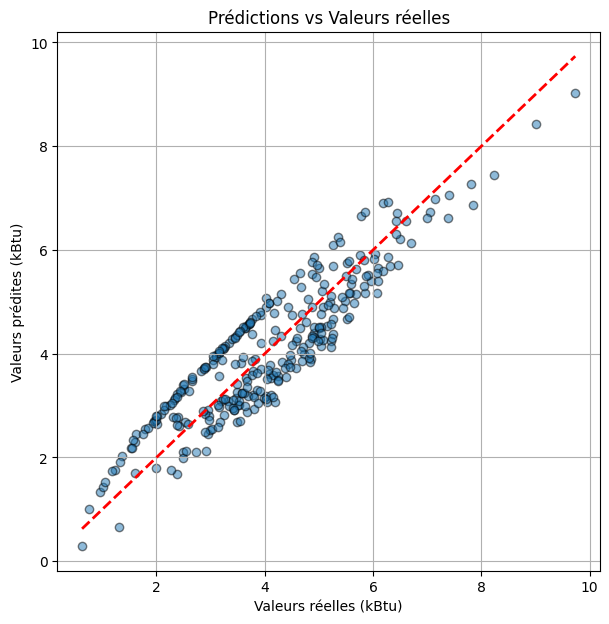

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model_Ridge.predict(X_test_trans)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R²   : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Valeurs réelles (kBtu)")
plt.ylabel("Valeurs prédites (kBtu)")
plt.title("Prédictions vs Valeurs réelles")
plt.grid(True)
plt.show()

In [17]:
import bentoml

pipeRidge = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model_Ridge)
])

pipeRidge.fit(X_train, y_train)

bentoml.sklearn.save_model("C02_emissions_model", pipeRidge)

[bentoml] Converting 'C02_emissions_model' to lowercase: 'c02_emissions_model'.


Model(tag="c02_emissions_model:aom7at4csoiheaav", path="/tmp/bentoml-model-c02_emissions_model-z0zjsffm")